# build model prediction and compare each features set

In [1]:
import pandas as pd
import xgboost as xgb
print("xgb version: " , xgb.__version__)
import pickle
import numpy as np
import os

from gensim.models import Doc2Vec, doc2vec

## turn back to main directory
os.chdir("../")
os.getcwd()
# os.chdir("Part2/")
# os.getcwd()

xgb version:  0.90


'C:\\Users\\user\\Desktop\\Resume\\V2.5\\v2-5-nlp\\Part2'

### Try
 - import SVM
 - import linear regression
 - import logistic regression

In [3]:
## read preprocess article df
df = pd.read_csv('data/article_preprocessed.csv')

In [5]:
## drop data
diff_threshold = 20
df = df[abs(df['push']-df['boo']) > diff_threshold].copy()

In [6]:
## define y
df['type'] = np.clip(df['push']-df['boo'], 0, 1)
df = df.reset_index(drop=True)

In [7]:
df['type'].value_counts()

1    17318
0     1134
Name: type, dtype: int64

-  258維 : 1維是Index 1維是y(output) 256維feature 

 - dtype = np.int32 : 將讀取進來的資料數值轉為 int (原先為float)

In [8]:
## create a numpy format data
basic_data = np.zeros((df.shape[0], 258), dtype = np.int32)

In [9]:
basic_data[:, 0] = df['idx']
basic_data[:, 1] = df['type']

In [10]:
basic_data[:,0]

array([    32,     39,     67, ..., 252173, 252195, 252199])

## bag of words

In [22]:
os.chdir("data/")
os.getcwd()

## load bag of words result
with open('article_count', 'rb') as file:
    _, count = pickle.load(file)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.4 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [23]:
## select top 256 words (counts of document) 
most_count_id = np.array((count > 0).sum(axis=0))[0].argsort()[::-1][:256]

In [24]:
## subset data
count = count[:, most_count_id]

In [25]:
count_data = basic_data.copy()

In [26]:
count_data[:, 0]
#count[count_data[:, 0]].toarray()

array([    32,     39,     67, ..., 252173, 252195, 252199])

In [27]:
## subset bag of words matrix
count_data[:, 2:] = count[count_data[:, 0]].toarray()
count_data[:, 2:]

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 8, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

## TF-IDF

In [28]:
## load tf-idf result
with open('article_tfidf', 'rb') as file:
    _, tfidf = pickle.load(file)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.4 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.4 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [29]:
## select top 256 words (counts of document) 
most_tfidf_id = np.array((tfidf > 0).sum(axis=0))[0].argsort()[::-1][:256]

In [30]:
## subset data
tfidf = tfidf[:, most_tfidf_id]

In [31]:
tfidf_data = basic_data.copy()

In [32]:
## subset tf-idf matrix
tfidf_data[:, 2:] = tfidf[tfidf_data[:, 0]].toarray()

## average word2vec

In [33]:
os.chdir("../")
os.getcwd()

'C:\\Users\\user\\Desktop\\Resume\\V2.5\\v2-5-nlp\\Part2'

In [34]:
## load average word2vec result
with open('avg_article_vector', 'rb') as file:
    avg_vector = pickle.load(file)

In [35]:
avg_data = basic_data.copy()

In [36]:
## select rows of average word2vec
for i, row in df.iterrows():
    avg_data[i, 2:] = avg_vector[row['idx']]

## doc2vec

In [37]:
## load doc2vec model
model = Doc2Vec.load('word2vec_model.doc2vec')

In [38]:
doc2vec_data = basic_data.copy()

In [39]:
## select idx of doc2vec
for i, row in df.iterrows():
    doc2vec_data[i, 2:] = model.docvecs[str(row['idx'])]

# prediction model

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
## split data to training and testing data
train, test = train_test_split(df, test_size=0.2, stratify=df['type'])
train_idx = np.array(train.index)
test_idx = np.array(test.index)

In [42]:
## define a dictionary to collect model result
result = {}

## train model use xgboost

In [43]:
## bag of words
model = xgb.XGBClassifier()
model.fit(count_data[train_idx, 2:], count_data[train_idx, 1], 
          eval_set=[(count_data[test_idx, 2:], count_data[test_idx, 1])], eval_metric='auc'
         )

## testing auc
result['bag_of_words'] = model.evals_result()['validation_0']['auc'][-1]

[0]	validation_0-auc:0.552041
[1]	validation_0-auc:0.56359
[2]	validation_0-auc:0.581314
[3]	validation_0-auc:0.581409
[4]	validation_0-auc:0.581436
[5]	validation_0-auc:0.581578
[6]	validation_0-auc:0.594223
[7]	validation_0-auc:0.600159
[8]	validation_0-auc:0.611402
[9]	validation_0-auc:0.610979
[10]	validation_0-auc:0.610523
[11]	validation_0-auc:0.611018
[12]	validation_0-auc:0.610667
[13]	validation_0-auc:0.610822
[14]	validation_0-auc:0.614745
[15]	validation_0-auc:0.614886
[16]	validation_0-auc:0.614998
[17]	validation_0-auc:0.638489
[18]	validation_0-auc:0.638674
[19]	validation_0-auc:0.63864
[20]	validation_0-auc:0.64123
[21]	validation_0-auc:0.644878
[22]	validation_0-auc:0.66001
[23]	validation_0-auc:0.666523
[24]	validation_0-auc:0.671359
[25]	validation_0-auc:0.670984
[26]	validation_0-auc:0.674533
[27]	validation_0-auc:0.68313
[28]	validation_0-auc:0.675305
[29]	validation_0-auc:0.679412
[30]	validation_0-auc:0.683463
[31]	validation_0-auc:0.688887
[32]	validation_0-auc:0

In [44]:
## tf-idf
model = xgb.XGBClassifier()
model.fit(tfidf_data[train_idx, 2:], tfidf_data[train_idx, 1], 
          eval_set=[(tfidf_data[test_idx, 2:], tfidf_data[test_idx, 1])], eval_metric='auc'
         )

## testing auc
result['tf-idf'] = model.evals_result()['validation_0']['auc'][-1]

[0]	validation_0-auc:0.552041
[1]	validation_0-auc:0.56359
[2]	validation_0-auc:0.581314
[3]	validation_0-auc:0.581409
[4]	validation_0-auc:0.581436
[5]	validation_0-auc:0.581578
[6]	validation_0-auc:0.594223
[7]	validation_0-auc:0.600159
[8]	validation_0-auc:0.611402
[9]	validation_0-auc:0.610979
[10]	validation_0-auc:0.610523
[11]	validation_0-auc:0.611018
[12]	validation_0-auc:0.610667
[13]	validation_0-auc:0.610822
[14]	validation_0-auc:0.614745
[15]	validation_0-auc:0.614886
[16]	validation_0-auc:0.614998
[17]	validation_0-auc:0.638489
[18]	validation_0-auc:0.638674
[19]	validation_0-auc:0.63864
[20]	validation_0-auc:0.64123
[21]	validation_0-auc:0.644878
[22]	validation_0-auc:0.66001
[23]	validation_0-auc:0.666523
[24]	validation_0-auc:0.671359
[25]	validation_0-auc:0.670984
[26]	validation_0-auc:0.674533
[27]	validation_0-auc:0.68313
[28]	validation_0-auc:0.675305
[29]	validation_0-auc:0.679412
[30]	validation_0-auc:0.683463
[31]	validation_0-auc:0.688887
[32]	validation_0-auc:0

In [99]:
## average word2vec
model = xgb.XGBClassifier()
model.fit(avg_data[train_idx, 2:], avg_data[train_idx, 1], 
          eval_set=[(avg_data[test_idx, 2:], avg_data[test_idx, 1])], eval_metric='auc'
         )

## testing auc
result['avg_word2vec'] = model.evals_result()['validation_0']['auc'][-1]

[0]	validation_0-auc:0.505041
[1]	validation_0-auc:0.505041
[2]	validation_0-auc:0.511261
[3]	validation_0-auc:0.511261
[4]	validation_0-auc:0.514511
[5]	validation_0-auc:0.514511
[6]	validation_0-auc:0.514511
[7]	validation_0-auc:0.514493
[8]	validation_0-auc:0.514511
[9]	validation_0-auc:0.514511
[10]	validation_0-auc:0.514511
[11]	validation_0-auc:0.516551
[12]	validation_0-auc:0.516551
[13]	validation_0-auc:0.516551
[14]	validation_0-auc:0.516541
[15]	validation_0-auc:0.516551
[16]	validation_0-auc:0.514895
[17]	validation_0-auc:0.514895
[18]	validation_0-auc:0.514895
[19]	validation_0-auc:0.514895
[20]	validation_0-auc:0.514895
[21]	validation_0-auc:0.514895
[22]	validation_0-auc:0.514895
[23]	validation_0-auc:0.51488
[24]	validation_0-auc:0.517917
[25]	validation_0-auc:0.517932
[26]	validation_0-auc:0.517932
[27]	validation_0-auc:0.517935
[28]	validation_0-auc:0.517935
[29]	validation_0-auc:0.517937
[30]	validation_0-auc:0.517937
[31]	validation_0-auc:0.517922
[32]	validation_0-a

In [100]:
## doc2vec
model = xgb.XGBClassifier()
model.fit(doc2vec_data[train_idx, 2:], doc2vec_data[train_idx, 1],
          eval_set=[(doc2vec_data[test_idx, 2:], doc2vec_data[test_idx, 1])], eval_metric='auc'
         )

## testing auc
result['doc2vec'] = model.evals_result()['validation_0']['auc'][-1]

[0]	validation_0-auc:0.499278
[1]	validation_0-auc:0.499134
[2]	validation_0-auc:0.499134
[3]	validation_0-auc:0.499134
[4]	validation_0-auc:0.499134
[5]	validation_0-auc:0.499134
[6]	validation_0-auc:0.499134
[7]	validation_0-auc:0.499134
[8]	validation_0-auc:0.498845
[9]	validation_0-auc:0.498845
[10]	validation_0-auc:0.498845
[11]	validation_0-auc:0.498845
[12]	validation_0-auc:0.498845
[13]	validation_0-auc:0.498845
[14]	validation_0-auc:0.498845
[15]	validation_0-auc:0.498845
[16]	validation_0-auc:0.498845
[17]	validation_0-auc:0.498845
[18]	validation_0-auc:0.498845
[19]	validation_0-auc:0.498268
[20]	validation_0-auc:0.498268
[21]	validation_0-auc:0.498268
[22]	validation_0-auc:0.498268
[23]	validation_0-auc:0.498268
[24]	validation_0-auc:0.498268
[25]	validation_0-auc:0.498557
[26]	validation_0-auc:0.498701
[27]	validation_0-auc:0.498845
[28]	validation_0-auc:0.498845
[29]	validation_0-auc:0.498845
[30]	validation_0-auc:0.498845
[31]	validation_0-auc:0.49899
[32]	validation_0-a

## plot result

In [101]:
import matplotlib.pyplot as plt

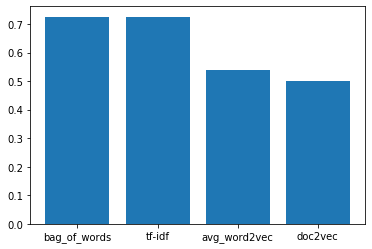

In [102]:
plt.bar(np.arange(4), result.values())
plt.xticks(np.arange(4), result.keys())
plt.show()